In [1]:
# Moment analysis
import os
import time
import yaml  # Saving results
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp  # CAS for exact matrix inverison
from matplotlib.backends.backend_pdf import PdfPages

# Inline plotting
%matplotlib inline

# Dir where simulations are in
sim_dir = os.path.abspath('/home/leloup/ownCloud/simulations/statistics/')

# Dir where plots are saved into
plot_dir = os.path.abspath('/home/leloup/Desktop/Uni/Master/p760_computational_physics/git/analysis/moment_analysis/plots')

In [2]:
# Get required prefix
def get_prefix(dim, l):
    """Returns required prefix"""
    return 'x'.join(str(l) for _ in range(dim))

# Function to load data of first and second moment which is going to be bootstrapped
def load_data(dim, model, observable, crit_slope=None):
    """Loads first and second moment data of observable of dim dimensions of model"""
    # Our lattice lengths are from 10 to 100
    lattices = np.arange(10, 110, 10)
    
    # 10 simulations per length
    n_samples = 10
    
    # Result matrices for 1st and second moment data
    moment1_data = np.zeros(shape=(n_samples, len(lattices)))
    moment2_data = np.zeros(shape=(n_samples, len(lattices)))
    
    for col, length in enumerate(lattices):
        sim_files = os.listdir(sim_dir)
        n_file = 0
        i = 0
        while n_file < n_samples:
            f = sim_files[i % len(sim_files)]
            if f.endswith('.npy'):
                tmp = f.split('.')[0].split('_')
                prefix = tmp[0]
                tmp_n = tmp[-1]
                tmp_model = tmp[-2]
                
                if tmp_model=='custom' and crit_slope is not None:
                    slope_flag = crit_slope == int(tmp[tmp.index('slope') + 1])
                else:
                    slope_flag = True

                if get_prefix(dim, length) == prefix and model==tmp_model and tmp_n==str(n_file) and slope_flag:
                    
                    # Load data
                    tmp_data = np.load(os.path.join(sim_dir, f))
                    
                    # Get observable
                    tmp_data = tmp_data[observable]
                    
                    # Moments
                    tmp_moment1 = np.log(np.mean(tmp_data))
                    tmp_moment2 = np.log(np.mean(np.power(tmp_data, 2)))
                    
                    # Write to reults
                    moment1_data[n_file, col] = tmp_moment1
                    moment2_data[n_file, col] = tmp_moment2
                    
                    # Increase file counter
                    n_file += 1
                    
            # Increase loop counter
            i+=1
    return moment1_data, moment2_data

In [3]:
def bootstrap_fit(moment1_data, moment2_data, n_bootstraps):
    """Bootstrap fitting of first and second moment data via frozen covariance approach"""
    
    # Number of samples
    n_samples = moment1_data.shape[0]
    
    # Length of samples
    l_samples = moment1_data.shape[1]
    sample_idx = np.arange(l_samples)
    
    # Bootstrap matrices
    bootstrapped_means_mom1 = np.zeros(shape=(n_bootstraps, l_samples))
    bootstrapped_means_mom2 = np.zeros(shape=(n_bootstraps, l_samples))
    
    # Do bootstrapping
    for k in range(n_bootstraps):
        
        # Bootstrap random idx with replacement
        rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        
        # Bootstrab entire data at once using same random idx
        bootstrap_sample_mom1 = moment1_data[rand_idx1, :]
        bootstrap_sample_mom2 = moment2_data[rand_idx2, :]
        
        # Take bootstrap mean column wise for one row at once
        bootstrapped_means_mom1[k,:] = np.mean(bootstrap_sample_mom1, axis=0)
        bootstrapped_means_mom2[k,:] = np.mean(bootstrap_sample_mom2, axis=0)
        
    # Bootstrap indices
    bootstrap_idx = np.arange(n_bootstraps)
    
    # Make mean matrix of bootstraped means
    mean_bootstraps_mom1 = np.zeros_like(bootstrapped_means_mom1)
    mean_bootstraps_mom2 = np.zeros_like(bootstrapped_means_mom2)
    
    # Fill mean matrix row wise with same rows of means
    mean_bootstraps_mom1[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom1, axis=0)
    mean_bootstraps_mom2[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom2, axis=0)
    
    # Diff between sampled means and overall means
    mean_diff_mom1 = bootstrapped_means_mom1 - mean_bootstraps_mom1
    mean_diff_mom2 = bootstrapped_means_mom2 - mean_bootstraps_mom2
    
    # Make covariance matrices
    cov_mat_mom1 = np.zeros(shape=(n_samples, n_samples))
    cov_mat_mom2 = np.zeros(shape=(n_samples, n_samples))
    
    # Fill covariance matrices
    for i in range(n_samples):
        for j in range(n_samples):
            cov_mat_mom1[i, j] = np.mean(mean_diff_mom1[:, i] * mean_diff_mom1[:, j])
            cov_mat_mom2[i, j] = np.mean(mean_diff_mom2[:, i] * mean_diff_mom2[:, j])
    
    cov_mat_mom1 = sp.Matrix(cov_mat_mom1)
    cov_mat_mom2 = sp.Matrix(cov_mat_mom2)
    cov_mat_inv1 = cov_mat_mom1.inv()
    cov_mat_inv2 = cov_mat_mom2.inv()
    
    cov_mat_inv1 = np.array(cov_mat_inv1).astype(np.float64)
    cov_mat_inv2 = np.array(cov_mat_inv2).astype(np.float64)
    
    # X fit values
    L = np.log(np.arange(10, 110, 10))
    
    # Z matrix
    z_mat = np.ones(shape=(n_samples, 2))
    z_mat[:,1] = L
    
    tmp1 = np.matmul(np.matmul(z_mat.T, cov_mat_inv1), z_mat)
    tmp2 = np.matmul(np.matmul(z_mat.T, cov_mat_inv2), z_mat)
    
    tmp1 = sp.Matrix(tmp1)
    tmp2 = sp.Matrix(tmp2)
    
    tmp_mat_mom1 = tmp1.inv()#np.linalg.inv(tmp1)
    tmp_mat_mom2 = tmp2.inv()#np.linalg.inv(tmp2)
    
    tmp_mat_mom1 = np.array(tmp_mat_mom1).astype(np.float64)
    tmp_mat_mom2 = np.array(tmp_mat_mom2).astype(np.float64)
    
    T_mat_mom1 = np.matmul(np.matmul(tmp_mat_mom1, z_mat.T), cov_mat_inv1)
    T_mat_mom2 = np.matmul(np.matmul(tmp_mat_mom2, z_mat.T), cov_mat_inv2)
    
    # Actual bootstrap fitting
    T_beta1 = np.zeros(shape=(n_bootstraps, 2))
    T_beta2 = np.zeros(shape=(n_bootstraps, 2))
    
    # Bootstrap matrices
    bootstrapped_means_mom1 = np.zeros(shape=(n_bootstraps, l_samples))
    bootstrapped_means_mom2 = np.zeros(shape=(n_bootstraps, l_samples))
    
    # Do bootstrapping
    for k in range(n_bootstraps):
        
        # Bootstrap random idx with replacement
        rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        
        # Bootstrab entire data at once using same random idx
        bootstrap_sample_mom1 = moment1_data[rand_idx1, :]
        bootstrap_sample_mom2 = moment2_data[rand_idx2, :]
        
        # Take bootstrap mean column wise for one row at once
        bootstrapped_means_mom1[k,:] = np.mean(bootstrap_sample_mom1, axis=0)
        bootstrapped_means_mom2[k,:] = np.mean(bootstrap_sample_mom2, axis=0)
    
    # Linear regression
    for k in range(n_bootstraps):
        T_beta1[k, :] = np.matmul(T_mat_mom1, bootstrapped_means_mom1[k, :])
        T_beta2[k, :] = np.matmul(T_mat_mom2, bootstrapped_means_mom2[k, :])
        
    # Calculate critical exponent, observable dimension D
    def tau(sigma1, sigma2):
        return 3.0 - sigma2/(sigma2-sigma1)
    
    def D(sigma1, sigma2):
        return sigma2 - sigma1
    
    # Results all bootstrap samples for critical exponent and observable dimension 
    bootstrap_critical_exponent = np.zeros(shape=n_bootstraps)
    bootstrap_dim_exponent = np.zeros(shape=n_bootstraps)
    
    for k in range(n_bootstraps):
        bootstrap_critical_exponent[k] = tau(T_beta1[k, 1], T_beta2[k, 1])
        bootstrap_dim_exponent[k] = D(T_beta1[k, 1], T_beta2[k, 1])
    
    final_critical_exponent = np.array([np.mean(bootstrap_critical_exponent), np.std(bootstrap_critical_exponent)])
    final_dim_exponent = np.array([np.mean(bootstrap_dim_exponent), np.std(bootstrap_dim_exponent)])
    final_logA1 = np.array([np.mean(T_beta1[:, 0]), np.std(T_beta1[:, 0])])
    final_sigma1 = np.array([np.mean(T_beta1[:, 1]), np.std(T_beta1[:, 1])])
    final_logA2 = np.array([np.mean(T_beta2[:, 0]), np.std(T_beta2[:, 0])])
    final_sigma2 = np.array([np.mean(T_beta2[:, 1]), np.std(T_beta2[:, 1])])
    
    return_dict = {'critical_exponent': final_critical_exponent, 'dim_exponent': final_dim_exponent, 'logA1': final_logA1,'logA2': final_logA2,
                   'sigma1': final_sigma1, 'sigma2': final_sigma2}
    
    return return_dict

In [4]:
def double_bootstrap_fit(moment1_data, moment2_data, n_bootstraps, n_inner):
    """Bootstrap fitting of first and second moment data via double bootstrap approach"""
    
    # Number of samples
    n_samples = moment1_data.shape[0]
    
    # Length of samples
    l_samples = moment1_data.shape[1]
    sample_idx = np.arange(l_samples)
    
    # Inner bootstrap indices
    bootstrap_idx = np.arange(n_inner)
    
    # Static matrices needed for fitting
    # X fit values
    L = np.log(np.arange(10, 110, 10))

    # Z matrix
    z_mat = np.ones(shape=(n_samples, 2))
    z_mat[:,1] = L
    
    # Store fit parameters of first and second moment fits
    T_beta1 = np.zeros(shape=(n_bootstraps, 2))
    T_beta2 = np.zeros(shape=(n_bootstraps, 2))
    
    # Do outer bootstrapping
    for k in range(n_bootstraps):
        
        # Bootstrap random idx with replacement
        rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        
        # Bootstrab entire data at once using same random idx
        bootstrap_sample_mom1 = moment1_data[rand_idx1, :]
        bootstrap_sample_mom2 = moment2_data[rand_idx2, :]
        
        # Double bootstrap matrices
        bootstrapped_means_mom1 = np.zeros(shape=(n_inner, l_samples))
        bootstrapped_means_mom2 = np.zeros(shape=(n_inner, l_samples))
        
        # Do double bootstrapping for outer bootstrap
        for l in range(n_inner):

            # Bootstrap random idx with replacement
            tmp_rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
            tmp_rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))

            # Bootstrab entire data at once using same random idx
            tmp_bootstrap_sample_mom1 = bootstrap_sample_mom1[tmp_rand_idx1, :]
            tmp_bootstrap_sample_mom2 = bootstrap_sample_mom2[tmp_rand_idx2, :]

            # Take bootstrap mean column wise for one row at once
            bootstrapped_means_mom1[l,:] = np.mean(tmp_bootstrap_sample_mom1, axis=0)
            bootstrapped_means_mom2[l,:] = np.mean(tmp_bootstrap_sample_mom2, axis=0)

        # Make mean matrix of bootstrapped means
        tmp_mean_bootstraps_mom1 = np.zeros_like(bootstrapped_means_mom1)
        tmp_mean_bootstraps_mom2 = np.zeros_like(bootstrapped_means_mom2)

        # Fill mean matrix row wise with same rows of means
        tmp_mean_bootstraps_mom1[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom1, axis=0)
        tmp_mean_bootstraps_mom2[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom2, axis=0)

        # Diff between sampled means and overall means
        tmp_mean_diff_mom1 = bootstrapped_means_mom1 - tmp_mean_bootstraps_mom1
        tmp_mean_diff_mom2 = bootstrapped_means_mom2 - tmp_mean_bootstraps_mom2

        # Make covariance matrices
        tmp_cov_mat_mom1 = np.zeros(shape=(n_samples, n_samples))
        tmp_cov_mat_mom2 = np.zeros(shape=(n_samples, n_samples))

        # Fill covariance matrices of double bootstrap
        for i in range(n_samples):
            for j in range(n_samples):
                tmp_cov_mat_mom1[i, j] = np.mean(tmp_mean_diff_mom1[:, i] * tmp_mean_diff_mom1[:, j])
                tmp_cov_mat_mom2[i, j] = np.mean(tmp_mean_diff_mom2[:, i] * tmp_mean_diff_mom2[:, j])
        
        # Use sympy CAS in order to calculate the exact inverse of matrices
        # Convert matrices from numpy to sympy matrices
        tmp_cov_mat_mom1 = sp.Matrix(tmp_cov_mat_mom1)
        tmp_cov_mat_mom2 = sp.Matrix(tmp_cov_mat_mom2)
        
        # Invert matrices
        tmp_cov_mat_inv1 = tmp_cov_mat_mom1.inv()
        tmp_cov_mat_inv2 = tmp_cov_mat_mom2.inv()
        
        # Convert back to numpy arrays
        tmp_cov_mat_inv1 = np.array(tmp_cov_mat_inv1).astype(np.float64)
        tmp_cov_mat_inv2 = np.array(tmp_cov_mat_inv2).astype(np.float64)
        
        # Calculate temporary matrices which need to be inverted as well
        tmp1 = np.matmul(np.matmul(z_mat.T, tmp_cov_mat_inv1), z_mat)
        tmp2 = np.matmul(np.matmul(z_mat.T, tmp_cov_mat_inv2), z_mat)
        
        # Convert matrices from numpy to sympy matrices
        tmp1 = sp.Matrix(tmp1)
        tmp2 = sp.Matrix(tmp2)
        
        # Invert matrices
        tmp_mat_mom1 = tmp1.inv()
        tmp_mat_mom2 = tmp2.inv()
        
        # Convert back to numpy arrays
        tmp_mat_mom1 = np.array(tmp_mat_mom1).astype(np.float64)
        tmp_mat_mom2 = np.array(tmp_mat_mom2).astype(np.float64)
        
        # Calculate T matrix which is needed for calculating fit parameters
        T_mat_mom1 = np.matmul(np.matmul(tmp_mat_mom1, z_mat.T), tmp_cov_mat_inv1)
        T_mat_mom2 = np.matmul(np.matmul(tmp_mat_mom2, z_mat.T), tmp_cov_mat_inv2)
        
        # Linear regression
        T_beta1[k, :] = np.matmul(T_mat_mom1, np.mean(bootstrap_sample_mom1, axis=0))
        T_beta2[k, :] = np.matmul(T_mat_mom2, np.mean(bootstrap_sample_mom2, axis=0))
        
    # Calculate critical exponent, observable dimension D
    def tau(sigma1, sigma2):
        return 3.0 - sigma2/(sigma2-sigma1)
    
    def D(sigma1, sigma2):
        return sigma2 - sigma1
    
    # Results all bootstrap samples for critical exponent and observable dimension 
    bootstrap_critical_exponent = np.zeros(shape=n_bootstraps)
    bootstrap_dim_exponent = np.zeros(shape=n_bootstraps)
    
    for k in range(n_bootstraps):
        bootstrap_critical_exponent[k] = tau(T_beta1[k, 1], T_beta2[k, 1])
        bootstrap_dim_exponent[k] = D(T_beta1[k, 1], T_beta2[k, 1])
    
    final_critical_exponent = np.array([np.mean(bootstrap_critical_exponent), np.std(bootstrap_critical_exponent)])
    final_dim_exponent = np.array([np.mean(bootstrap_dim_exponent), np.std(bootstrap_dim_exponent)])
    final_logA1 = np.array([np.mean(T_beta1[:, 0]), np.std(T_beta1[:, 0])])
    final_sigma1 = np.array([np.mean(T_beta1[:, 1]), np.std(T_beta1[:, 1])])
    final_logA2 = np.array([np.mean(T_beta2[:, 0]), np.std(T_beta2[:, 0])])
    final_sigma2 = np.array([np.mean(T_beta2[:, 1]), np.std(T_beta2[:, 1])])
    
    return_dict = {'critical_exponent': final_critical_exponent, 'dim_exponent': final_dim_exponent, 'logA1': final_logA1,'logA2': final_logA2,
                   'sigma1': final_sigma1, 'sigma2': final_sigma2}
    
    return return_dict

In [15]:
### Basically this is the main ###

results = {'duration': {}, 'size': {}, 'area': {}}
n_bootstraps = 40  # Rule of thumb: n_bootstraps = 4 * n_samples
n_inner = 20000 # Number of double bootstraps
n_fits = 100  # Number of fits
dim = 2
model = 'custom'
crit_slope = 7
# Do n_fits in order to get the quantities with minimum uncertainty for all extracted quantities
for i in range(n_fits):
    # Feedback
    print '===Fit %i===' % i
    
    # Make temporary result
    tmp_results = {'duration': None, 'size': None, 'area': None}
    
    # Loop over observables
    for observable in tmp_results.keys():
        
        # Load first and second moment from data
        mom1, mom2 = load_data(dim, model, observable, crit_slope=crit_slope)
        
        # Try doing bootstrap fits; ValueError occurs if some matrix is not invertable
        try:
            # Do double bootstrap fit for observable's moments
            tmp_results[observable] = double_bootstrap_fit(mom1, mom2, n_bootstraps, n_inner)
            
            # Loop over extraction quantities and write tmp results to final result dict;
            # Convert everything to floats in order to safe to file
            for key in tmp_results[observable].keys():
                
                # First iteration of n_fits: initialize values in result dict
                if key not in results[observable]:
                    results[observable][key] = []
                    for j in range(len(tmp_results[observable][key])):
                        results[observable][key].append(float(tmp_results[observable][key][j]))
                
                # Overwrite if lower deviation on quantity has been achieved within this fit
                elif tmp_results[observable][key][1] < results[observable][key][1]:
                    for j in range(len(tmp_results[observable][key])):
                        results[observable][key][j] = float(tmp_results[observable][key][j])
        
        # Matrix inversion failed
        except ValueError:
            print 'Skipped'
            continue

# Safe results
model_str = model if model == 'btw' else model + '_crit_slope_%i' % crit_slope
with open('results%id_%s.yaml' % (dim, model_str), 'w') as f:
    yaml.safe_dump(results, stream=f, default_flow_style=False)


===Fit 0===
##############
[[  1.          -0.89939352  -0.7722876    0.54872004   2.48767315
   -0.60655299   0.99506875  -2.55703761  -4.67236575  -1.94739159]
 [ -0.89939352   1.77092116   2.80070409   0.65085655  -2.77933139
    1.95373781  -0.20341981   4.14752517   6.84220103   0.59843027]
 [ -0.7722876    2.80070409   9.69208022   2.42304061  -4.88197877
    5.83053352   0.39435774  13.90027603   8.77814521   0.22816294]
 [  0.54872004   0.65085655   2.42304061   2.51151933   1.28661979
    2.0671441    0.50836824   2.06684264   0.463098    -1.56002018]
 [  2.48767315  -2.77933139  -4.88197877   1.28661979   8.50083535
   -2.23022065   0.06147277 -11.25622886 -12.28943136  -2.36615757]
 [ -0.60655299   1.95373781   5.83053352   2.0671441   -2.23022065
    6.17603303  -2.43251711   5.23940889   6.43468425   1.15687943]
 [  0.99506875  -0.20341981   0.39435774   0.50836824   0.06147277
   -2.43251711   5.95813612   1.63448446  -3.73568282  -6.66821769]
 [ -2.55703761   4.14752517 

##############
[[  1.          -0.93645455  -3.03355382   0.32572754   0.34160893
   -1.27976141   3.36093683  -2.62455944  -6.26792904  -2.80728135]
 [ -0.93645455   2.6990222    3.82916435   1.83403218  -3.73462585
    2.56753971  -0.22525319   5.22200906  10.55619395   3.24164442]
 [ -3.03355382   3.82916435  16.03667942   1.8534317   -3.70374352
   10.10270722 -13.13233551   8.17305556  24.39949946  10.6840153 ]
 [  0.32572754   1.83403218   1.8534317    6.44850202  -6.26342651
    0.47060841   5.15850156   6.15593683   6.20538971   3.63249153]
 [  0.34160893  -3.73462585  -3.70374352  -6.26342651  27.17161932
   -1.50926098 -18.92285971 -35.31063667  -4.51675521  -9.22526584]
 [ -1.27976141   2.56753971  10.10270722   0.47060841  -1.50926098
    9.21742351  -7.20797525   1.44672763  12.02835473   1.50782008]
 [  3.36093683  -0.22525319 -13.13233551   5.15850156 -18.92285971
   -7.20797525  31.5588233   19.98548917 -22.25165802  -7.6662684 ]
 [ -2.62455944   5.22200906   8.17305556

##############
[[ 1.         -0.37531801  1.19390309  1.40937893  1.37003424  0.82602498
   1.23693609  1.15280164 -3.23080484 -0.52142897]
 [-0.37531801  1.44487662  0.27646606 -0.733737   -0.41574088  1.69202216
  -0.05481365  0.52044372  4.89625764  2.16727098]
 [ 1.19390309  0.27646606  5.24950962  2.43626159 -0.35947167  3.12977734
   1.35152808  7.76347845 -1.30555757  3.02829706]
 [ 1.40937893 -0.733737    2.43626159  4.9075491  -2.49443357 -0.24091532
   3.48209169  4.45807917 -3.83351967  1.22144685]
 [ 1.37003424 -0.41574088 -0.35947167 -2.49443357 10.26569914  1.42220567
  -1.35183948 -3.15716021 -5.54156841 -3.4829123 ]
 [ 0.82602498  1.69202216  3.12977734 -0.24091532  1.42220567  6.34874924
   0.30127202 -0.42226334  2.3189689   0.70095746]
 [ 1.23693609 -0.05481365  1.35152808  3.48209169 -1.35183948  0.30127202
   4.07989575  5.57642027 -2.60977613  1.75888892]
 [ 1.15280164  0.52044372  7.76347845  4.45807917 -3.15716021 -0.42226334
   5.57642027 29.54247988 -0.5694804

##############
[[ 1.00000000e+00 -3.77078818e-01  5.32226777e-01  1.62315460e+00
  -1.17212649e+00 -4.40181578e-02  3.41926923e+00  4.01756839e+00
  -4.23092148e+00 -2.08482270e-01]
 [-3.77078818e-01  6.07765202e-01  3.77872927e-01  2.44147830e-01
  -1.74733308e-01  2.59018400e-01 -7.23258358e-01 -2.61292767e-01
   3.07898938e+00  5.17442788e-01]
 [ 5.32226777e-01  3.77872927e-01  7.68640688e+00  5.74534213e+00
   5.09882605e-01  2.84090584e+00 -2.69031342e+00  5.42706482e+00
   4.87654821e+00  5.00805254e+00]
 [ 1.62315460e+00  2.44147830e-01  5.74534213e+00  7.58933811e+00
  -3.62218212e+00  1.07898615e+00  3.91174895e+00  1.01302363e+01
   5.48622270e-01  6.20715507e+00]
 [-1.17212649e+00 -1.74733308e-01  5.09882605e-01 -3.62218212e+00
   5.05709580e+00  1.51616400e+00 -6.65507201e+00 -6.31633592e+00
   2.17173550e+00 -3.38980603e+00]
 [-4.40181578e-02  2.59018400e-01  2.84090584e+00  1.07898615e+00
   1.51616400e+00  1.59136376e+00 -2.04369173e+00  9.40299855e-01
   1.92885138e+00 

##############
[[  1.          -0.06386618   0.73260526   1.15609062   0.3695972
    0.31053667   3.01584543   2.37440924  -3.21371378  -1.50016466]
 [ -0.06386618   1.07764361   0.73852454  -0.74649347  -0.07238528
    1.473894     0.86544129   1.21307604   2.68074652   0.2802522 ]
 [  0.73260526   0.73852454   6.01341745   1.72666162   0.69030718
    1.64217023   1.01445208   4.90326477   2.50633663   0.12808138]
 [  1.15609062  -0.74649347   1.72666162   3.76370867  -1.7684553
   -0.1917378    2.66626537   4.27182793  -3.9008418    1.36415114]
 [  0.3695972   -0.07238528   0.69030718  -1.7684553    8.74035966
    1.00526538  -4.56352947  -6.79782137   0.77562644  -1.48770428]
 [  0.31053667   1.473894     1.64217023  -0.1917378    1.00526538
    3.84990358  -0.29201655   0.82968159   3.36995798   2.76840673]
 [  3.01584543   0.86544129   1.01445208   2.66626537  -4.56352947
   -0.29201655  17.13127893  13.86863715 -10.69965437  -8.87724721]
 [  2.37440924   1.21307604   4.90326477  

##############
[[  1.          -0.46014842  -0.37405512   0.15824133   1.0577063
    0.06835715   2.59094434   1.17767853  -4.74417746  -1.52053242]
 [ -0.46014842   2.80382508   2.75527961   0.46503117  -0.23307975
    3.29595401   0.69015324   3.95109847   8.45276538   0.75520916]
 [ -0.37405512   2.75527961  10.66382176   2.26386802   2.79328988
    7.15956051  -4.26672317   7.53653315  10.70842145   0.97789606]
 [  0.15824133   0.46503117   2.26386802   2.7095239   -0.19597185
    0.81407975   0.25714667   3.05635955   1.16928007  -0.82120412]
 [  1.0577063   -0.23307975   2.79328988  -0.19597185  10.08324603
    3.75322937  -5.58523763  -6.443584    -0.10407787   0.56005453]
 [  0.06835715   3.29595401   7.15956051   0.81407975   3.75322937
    9.34151525  -2.9232663    7.09146913   8.49299698   3.21610862]
 [  2.59094434   0.69015324  -4.26672317   0.25714667  -5.58523763
   -2.9232663   18.55643318  11.74998813 -12.17891766  -8.42783192]
 [  1.17767853   3.95109847   7.53653315 

##############
[[  1.          -1.12159546  -1.4978112    0.19728355   0.77564705
   -0.45458734   1.75970452  -4.10693192  -5.50650422  -2.28645971]
 [ -1.12159546   4.04426088   5.47218504   3.28034312  -3.70583902
    3.8329476    0.6448001    5.74340332  14.56714429   0.27634252]
 [ -1.4978112    5.47218504  12.13821434   4.32626449  -8.25889675
   10.83659291  -0.15079137  11.02750374  18.08220407  -0.82881219]
 [  0.19728355   3.28034312   4.32626449   8.90225342  -7.97062297
    4.41837696   4.22800144   7.23896092  10.75215936   5.2307244 ]
 [  0.77564705  -3.70583902  -8.25889675  -7.97062297  17.60378919
   -2.1848543   -8.59834246 -22.24187661 -14.13837312 -10.02139226]
 [ -0.45458734   3.8329476   10.83659291   4.41837696  -2.1848543
   16.07451484  -5.82755939   0.06922123  10.34196637  -2.81465233]
 [  1.75970452   0.6448001   -0.15079137   4.22800144  -8.59834246
   -5.82755939  16.60094108   5.77126665  -2.3569856   -8.08118871]
 [ -4.10693192   5.74340332  11.02750374 

##############
[[  1.          -0.26415598  -0.52674835   0.23165755  -0.71948775
    0.54828121   3.84482629   2.7510252   -5.27540453  -1.72079502]
 [ -0.26415598   2.41373281   1.83636128   0.69230539   0.07837468
    3.08230654   0.83835276   2.74850372   6.65655128   0.25941722]
 [ -0.52674835   1.83636128   9.67260783   2.76066871   5.73826619
    6.82565491  -7.72642242   2.16356712   9.94518621   0.47338611]
 [  0.23165755   0.69230539   2.76066871   2.61504749  -0.76749967
    1.52451056   0.79366061   2.65366046   1.3734312   -1.77588401]
 [ -0.71948775   0.07837468   5.73826619  -0.76749967   7.36802003
    3.11091361  -9.14957226  -0.34144646   6.10820045   3.87184883]
 [  0.54828121   3.08230654   6.82565491   1.52451056   3.11091361
    9.51394703  -0.43073669   3.54374792   5.92757828  -2.68494759]
 [  3.84482629   0.83835276  -7.72642242   0.79366061  -9.14957226
   -0.43073669  23.40428185  13.21317104 -19.00900181  -7.25949458]
 [  2.7510252    2.74850372   2.16356712

##############
[[ 1.00000000e+00 -6.04081423e-01 -1.09773651e+00  1.37291427e-01
   1.92412473e+00 -3.28543519e-01  1.82088215e+00 -9.21680307e-01
  -4.58303692e+00 -1.17348081e+00]
 [-6.04081423e-01  2.42817894e+00  3.17224591e+00  6.09605978e-01
  -1.03932887e+00  3.57540786e+00  1.55334090e-01  5.26091965e+00
   7.40242835e+00  9.09687252e-01]
 [-1.09773651e+00  3.17224591e+00  9.77394700e+00  2.87994099e+00
  -7.92316743e-01  7.01592959e+00 -3.29410215e+00  1.06874842e+01
   1.19888868e+01  1.10954546e+00]
 [ 1.37291427e-01  6.09605978e-01  2.87994099e+00  2.11380913e+00
   8.82778081e-02  1.29161514e+00  2.04739432e-02  3.24357847e+00
   1.73389363e+00 -6.41498325e-01]
 [ 1.92412473e+00 -1.03932887e+00 -7.92316743e-01  8.82778081e-02
   1.27847655e+01  9.93825481e-01 -3.71774695e+00 -1.19214307e+01
  -3.98310375e+00 -1.51743048e+00]
 [-3.28543519e-01  3.57540786e+00  7.01592959e+00  1.29161514e+00
   9.93825481e-01  7.48112432e+00 -4.79775003e-01  9.20847400e+00
   9.64802048e+00 

##############
[[  1.           0.14096621  -2.00908671  -0.63913496   1.23021109
    0.42707958   3.39330256   0.23777324  -3.76947992  -0.67770311]
 [  0.14096621   3.43358417   3.28110699   1.46613938  -2.25128066
    3.51031871   5.03853111   8.76905736   7.59013718   0.34126011]
 [ -2.00908671   3.28110699  14.92719399   2.66453488   0.82969154
    7.76326078  -9.13534272   8.30114686  20.34828482   5.08376971]
 [ -0.63913496   1.46613938   2.66453488   5.06437106  -4.65919916
    0.56792425  -0.95573501   4.11268398   9.41422452   7.81474612]
 [  1.23021109  -2.25128066   0.82969154  -4.65919916  31.64695788
    4.16590945 -20.02330558 -32.99729613  -0.8574031   -6.58845544]
 [  0.42707958   3.51031871   7.76326078   0.56792425   4.16590945
   11.25246526  -1.74479911   9.88487033   7.22510667   3.62115046]
 [  3.39330256   5.03853111  -9.13534272  -0.95573501 -20.02330558
   -1.74479911  37.28781334  30.50619886 -11.98676403  -5.73096783]
 [  0.23777324   8.76905736   8.30114686

##############
[[  1.          -0.03660613  -0.42854567   0.5933027    1.2831251
    0.52776523   2.42974344   0.46751429  -3.16244258  -0.76920306]
 [ -0.03660613   2.51861868   2.91060519   0.2489604    0.3024115
    4.54274927   1.16421479   5.24682612   5.86602951   1.07999881]
 [ -0.42854567   2.91060519   8.38899794   3.57073573  -0.64068087
    6.10661834  -1.55172852   9.68750443  10.41990876   2.7429829 ]
 [  0.5933027    0.2489604    3.57073573   3.55863913  -1.84093943
    1.52865748   1.26130301   4.46421201   0.43273178   0.99931636]
 [  1.2831251    0.3024115   -0.64068087  -1.84093943  14.20317442
    2.4608874   -4.29440733 -10.55702882  -0.69073199  -3.17059244]
 [  0.52776523   4.54274927   6.10661834   1.52865748   2.4608874
    9.21075064   2.13026692   8.10595493   9.58189021   0.60162487]
 [  2.42974344   1.16421479  -1.55172852   1.26130301  -4.29440733
    2.13026692  12.68889859  11.11931059  -8.33266545  -0.89630351]
 [  0.46751429   5.24682612   9.68750443   

##############
[[ 1.00000000e+00 -3.50282473e-01 -1.28271412e-01  9.72125471e-01
  -3.57230456e-01 -5.15320672e-03  3.49409801e+00  2.56103208e+00
  -4.85148988e+00 -1.96961116e+00]
 [-3.50282473e-01  4.67965062e-01 -1.23674980e-01 -3.37180248e-01
  -9.20831335e-01 -5.27369094e-02 -3.99688048e-03 -2.48564106e-01
   2.18378764e+00  2.84041628e-01]
 [-1.28271412e-01 -1.23674980e-01  4.95454846e+00  5.32949777e-02
   3.32076516e+00  1.31661658e+00 -4.54428941e+00 -7.76893661e-01
   3.27334183e+00  7.44531955e-01]
 [ 9.72125471e-01 -3.37180248e-01  5.32949777e-02  1.02833303e+00
   1.52018171e-02 -7.56656213e-02  3.05259698e+00  2.47651854e+00
  -4.40338518e+00 -1.55214357e+00]
 [-3.57230456e-01 -9.20831335e-01  3.32076516e+00  1.52018171e-02
   8.35441614e+00  6.59067853e-01 -9.72296182e+00 -8.65487121e+00
   4.25704102e+00  2.09802618e+00]
 [-5.15320672e-03 -5.27369094e-02  1.31661658e+00 -7.56656213e-02
   6.59067853e-01  1.76748529e+00 -2.13828627e+00 -1.47509102e+00
   4.93027872e-01 

##############
[[ 1.00000000e+00 -2.92556485e-01  5.04935960e-02  6.39292295e-01
   2.94200906e+00  2.85303783e-01  1.08704938e+00 -9.90459706e-01
  -3.08582834e+00 -1.36996566e+00]
 [-2.92556485e-01  1.65759226e+00  1.38350704e+00 -7.23417282e-01
   8.62445478e-03  2.39816968e+00  5.70560684e-01  2.50718450e+00
   4.50462298e+00  4.29002095e-01]
 [ 5.04935960e-02  1.38350704e+00  4.27995768e+00  1.26113456e+00
  -1.26495423e+00  2.17487428e+00  1.92675701e+00  6.82378753e+00
   3.05795389e+00 -1.48964112e+00]
 [ 6.39292295e-01 -7.23417282e-01  1.26113456e+00  1.89234124e+00
   7.78820044e-01 -2.00180196e-01  2.64637937e-01  1.11164464e+00
  -3.11666933e+00 -1.11128921e+00]
 [ 2.94200906e+00  8.62445478e-03 -1.26495423e+00  7.78820044e-01
   1.12401314e+01  2.85556100e+00  1.99565516e+00 -5.53771267e+00
  -6.99506182e+00 -2.24287566e+00]
 [ 2.85303783e-01  2.39816968e+00  2.17487428e+00 -2.00180196e-01
   2.85556100e+00  4.70494848e+00  6.39232612e-01  2.77578614e+00
   4.91971939e+00 

##############
[[ 1.         -0.28564453  1.26767918  1.53766831  2.46855804  0.61181097
   0.95205388  1.02568437 -3.00663599 -1.31574646]
 [-0.28564453  4.29334934  4.5560256  -0.23144132  1.71614849  7.82957021
   0.6319672   6.30038255 10.72303005  0.99126823]
 [ 1.26767918  4.5560256  14.60666406  7.2797584   2.04711053 11.46820095
   2.62484045 20.09234932  7.97010231 -2.53213008]
 [ 1.53766831 -0.23144132  7.2797584   6.24085526  0.84120577  2.60257417
   1.67817582  8.22669122 -3.92983621 -4.04520521]
 [ 2.46855804  1.71614849  2.04711053  0.84120577  9.96287852  5.02669536
   2.7686642   1.96459368 -1.91783618 -0.9916005 ]
 [ 0.61181097  7.82957021 11.46820095  2.60257417  5.02669536 16.18559919
   2.27620949 13.64359413 16.98009724 -0.94837922]
 [ 0.95205388  0.6319672   2.62484045  1.67817582  2.7686642   2.27620949
   1.14236994  3.35621403 -0.73863037 -0.93329488]
 [ 1.02568437  6.30038255 20.09234932  8.22669122  1.96459368 13.64359413
   3.35621403 35.39617644 12.6515819

##############
[[ 1.         -0.11825394  0.07026165  0.28482068  0.46215477 -0.18958027
   0.93569799  0.57301658 -2.04883903 -1.6938346 ]
 [-0.11825394  0.2679541   0.3805959   0.2803667  -0.25323329  0.40304162
  -0.25759661  0.41430088  0.44263758  0.2408901 ]
 [ 0.07026165  0.3805959   1.26815952  0.5733848   0.11015964  0.55243336
  -0.43422643  0.79203469  0.87150208 -0.06953818]
 [ 0.28482068  0.2803667   0.5733848   1.56038758 -0.14781883 -0.47043413
  -0.68365644  0.51241502 -1.02466029 -1.15167735]
 [ 0.46215477 -0.25323329  0.11015964 -0.14781883  1.14840323 -0.0354716
  -0.22941952 -0.9400456  -0.18287513 -0.24633179]
 [-0.18958027  0.40304162  0.55243336 -0.47043413 -0.0354716   1.63671038
  -0.03488417  0.57658592  1.67745739  1.11762981]
 [ 0.93569799 -0.25759661 -0.43422643 -0.68365644 -0.22941952 -0.03488417
   2.47185603  1.61545504 -2.25895938 -1.8488795 ]
 [ 0.57301658  0.41430088  0.79203469  0.51241502 -0.9400456   0.57658592
   1.61545504  2.9308369  -1.11533933

##############
[[ 1.         -0.43169162 -0.56612101 -0.096483    0.94643614 -0.86028389
   0.64550875 -0.86208168 -2.5894779  -1.5793607 ]
 [-0.43169162  0.60261353  0.54444498  0.46254469 -0.44471889  0.95405897
  -0.82440495  0.41128443  1.07499346  0.47389129]
 [-0.56612101  0.54444498  1.35782168  1.05976948 -0.49450729  0.85746796
  -1.03438231  1.29682313  2.34395106  0.76048862]
 [-0.096483    0.46254469  1.05976948  2.0046742  -0.8009059   0.76316816
  -0.99739786  1.7471472   1.36495896  1.31774115]
 [ 0.94643614 -0.44471889 -0.49450729 -0.8009059   3.09116525 -0.830189
  -1.22076956 -4.2978266  -2.1745994  -1.99360232]
 [-0.86028389  0.95405897  0.85746796  0.76316816 -0.830189    1.58889665
  -1.49025159  0.64099015  2.20653776  1.2970552 ]
 [ 0.64550875 -0.82440495 -1.03438231 -0.99739786 -1.22076956 -1.49025159
   3.61341017  2.37724653 -2.56211085 -1.56996425]
 [-0.86208168  0.41128443  1.29682313  1.7471472  -4.2978266   0.64099015
   2.37724653  7.29847989  2.63220799 

##############
[[ 1.         -0.82197006  0.45260242 -1.35461189  0.62880177  1.22011997
   2.89344857  1.99587663 -0.92452686 -0.57232266]
 [-0.82197006  3.75018551  1.46508542  1.32835635 -0.70150738 -0.5889944
  -4.28136796 -0.29014598 10.16523453  2.28387207]
 [ 0.45260242  1.46508542  3.34887725 -2.00444362  1.5458071   5.70319357
  -0.36020418  0.5235069   3.33424312  2.6008978 ]
 [-1.35461189  1.32835635 -2.00444362  7.15603594 -4.08664121 -3.78744717
  -3.71459079  3.2792004   4.55249364  1.02932894]
 [ 0.62880177 -0.70150738  1.5458071  -4.08664121  2.8512691   3.51134696
   1.60309378 -2.33254048 -3.53550033 -1.38576447]
 [ 1.22011997 -0.5889944   5.70319357 -3.78744717  3.51134696 14.00721453
   1.97439111  1.49455404 -4.23456019  3.34490622]
 [ 2.89344857 -4.28136796 -0.36020418 -3.71459079  1.60309378  1.97439111
   9.68946255  5.17966515 -8.02268546 -3.24602129]
 [ 1.99587663 -0.29014598  0.5235069   3.2792004  -2.33254048  1.49455404
   5.17966515 11.2800194   4.9657157 

##############
[[ 1.         -0.26498425 -0.56144519 -0.25328154  0.94736321  0.00875708
   0.8329915  -0.81348815 -1.76618926 -1.30354762]
 [-0.26498425  0.53114088  0.30221101  0.36118365 -0.51105662  0.37634169
  -0.40671035  0.32503296  1.16170771  0.321387  ]
 [-0.56144519  0.30221101  1.27638428 -0.08462191 -0.09340675  1.26799656
  -0.6199077   0.58740022  2.09127845  1.29728717]
 [-0.25328154  0.36118365 -0.08462191  1.09434334 -0.16841567 -0.13235924
  -1.21245741 -1.12053073  0.3495611  -0.1642491 ]
 [ 0.94736321 -0.51105662 -0.09340675 -0.16841567  2.16750658 -0.23621756
  -0.48996824 -1.98020171 -0.81005467 -0.57129217]
 [ 0.00875708  0.37634169  1.26799656 -0.13235924 -0.23621756  2.86503713
   0.53307734  0.64629546  0.2752389   0.44967496]
 [ 0.8329915  -0.40671035 -0.6199077  -1.21245741 -0.48996824  0.53307734
   3.15563859  1.60933395 -2.57857162 -1.71939263]
 [-0.81348815  0.32503296  0.58740022 -1.12053073 -1.98020171  0.64629546
   1.60933395  5.63613512  2.1836296

KeyboardInterrupt: 

In [13]:
with open('n_bootstraps_40_n_inner_20000/results3d_btw.yaml', 'r') as f:
    results = yaml.safe_load(f)
dim=3
model='btw'
crit_slope=5
print results

{'duration': {'dim_exponent': [1.4149740384038103, 0.0559014384603214], 'critical_exponent': [1.4538242720207226, 0.02769079677825407], 'sigma1': [0.7690147340840314, 0.014565192459095608], 'logA1': [-1.5924220265700513, 0.056789639306772374], 'logA2': [-2.194557200252886, 0.12624179887352963], 'sigma2': [2.1842041529029403, 0.03337476459884264]}, 'area': {'dim_exponent': [2.5900276909870614, 0.7119089345734876], 'critical_exponent': [1.4231698980027736, 0.29226755687548495], 'sigma1': [1.610655063177024, 0.1160196842066689], 'logA1': [-1.5361073047079448, 0.3739038715572823], 'logA2': [-2.275251370875721, 2.2138723120370627], 'sigma2': [4.191695182517597, 0.6988857366926224]}, 'size': {'dim_exponent': [2.548610252874179, 0.3318132146874306], 'critical_exponent': [1.2592965742016946, 0.1297207689158107], 'sigma1': [1.8204805200703067, 0.09337385668128803], 'logA1': [-3.0711322530508545, 0.32842192572928236], 'logA2': [-4.58789488609961, 1.1600349890172124], 'sigma2': [4.397435480917925

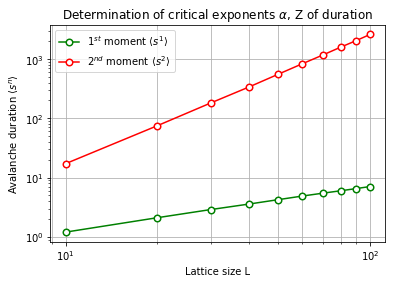

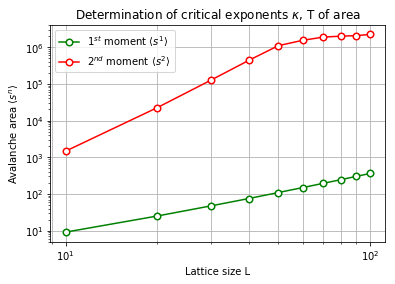

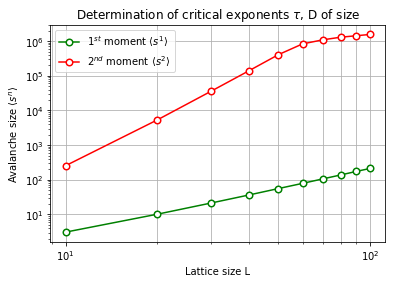

In [15]:
def fit(x, a, b):
    return np.exp(a) * np.power(x, b)
# Critical exponents:
# Avalanche size exponent tau; avalanche dimension D
# Avalanche duration exponent alpha; dynamic exponent z
# D,z and tau, aplha are STANDARD SET OF SOC EXPONENTS of a SOC model (page 22 SOC book)
# Avalanche area exponent lambda; f
critical_exponents = {'duration': [r'$\alpha$', 'Z'], 'size': [r'$\tau$', 'D'], 'area': [r'$\kappa$', 'T']}
x = np.arange(10,110,10)
for field in results.keys():
    mom1, mom2 = load_data(dim, model, field)
    res = results[field]
    ce = critical_exponents[field]
    plt.plot(x, np.exp(np.mean(mom1, axis=0)),c='g', label=r'$ 1^{st}\ \mathrm{moment}\ \left< s^1 \right>$', marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    plt.plot(x, np.exp(np.mean(mom2, axis=0)),c='r', label=r'$ 2^{nd}\ \mathrm{moment}\ \left< s^2 \right>$', marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    #plt.plot(x, np.exp(np.mean(mom1, axis=0)),ls='None',c='g', label=r'$ 1^{st}\ \mathrm{moment}\ \left< s^1 \right>$', marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    #plt.plot(x, np.exp(np.mean(mom2, axis=0)),ls='None',c='r', label=r'$ 2^{nd}\ \mathrm{moment}\ \left< s^2 \right>$', marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    #plt.plot(x, fit(x, res['logA1'][0], res['sigma1'][0]), c='g', ls='--', label=r'Linear fit $\left< s^1 \right>$')
    #plt.plot(x, fit(x, res['logA2'][0], res['sigma2'][0]), c='r', ls='--', label=r'Linear fit $\left< s^2 \right>$')
    plt.title(r'Determination of critical exponents %s, %s of %s' % (ce[0], ce[1], field))
    plt.xlabel('Lattice size L')
    plt.ylabel(r'Avalanche %s $\left< s^n \right>$' % field)
    plt.loglog()
    plt.grid(which='both', axis='x')
    plt.grid(which='major', axis='y')
    plt.legend()
    model_str = model if model == 'btw' else model + '_crit_slope_%i' % crit_slope
    out = os.path.join(plot_dir, 'moment_analysis_%s_%id_%s.pdf' % (field, dim, model_str))
    plt.savefig(out)
    plt.show()

In [54]:
results

{'area': {'critical_exponent': [1.3741321850540649, 0.4734149892504714],
  'dim_exponent': [0.8443765285557842, 0.3073484599938006],
  'logA1': [-1.4253549501442655, 0.7073493332864147],
  'logA2': [-1.512860983418011, 0.35592142456660586],
  'sigma1': [0.6628204775958524, 0.21829148589654793],
  'sigma2': [1.4858873459191109, 0.09248138498349324]},
 'duration': {'critical_exponent': [1.2011748452541418, 0.44611341550869377],
  'dim_exponent': [0.7309465289564867, 0.13919405441554178],
  'logA1': [-1.3681004440459836, 0.2934809348715467],
  'logA2': [-1.1663658132983787, 0.5240684963137046],
  'sigma1': [0.6014753960290039, 0.12376409680697838],
  'sigma2': [1.3038702561263011, 0.11936052844066374]},
 'size': {'critical_exponent': [1.3883752601100787, 0.4251689712286392],
  'dim_exponent': [1.710665143384162, 0.6785638938269463],
  'logA1': [-2.1917820342297767, 0.6803722923153546],
  'logA2': [-3.6469246604478784, 1.2677801261119142],
  'sigma1': [1.0249360395564229, 0.172038040820967